In [26]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import ml_util as util


In [27]:
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df_full = pd.concat([training, test])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

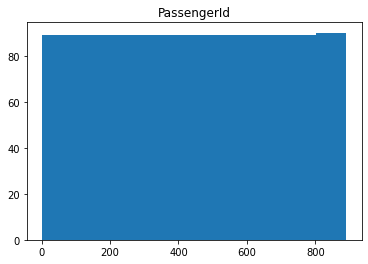

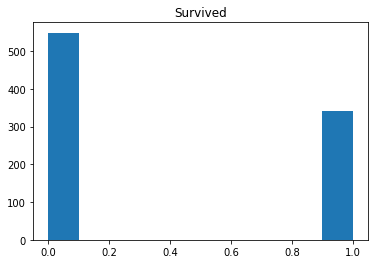

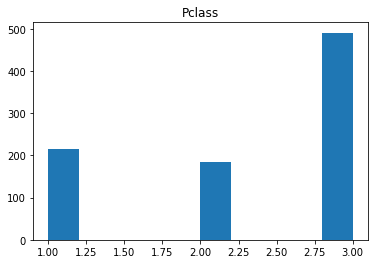

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


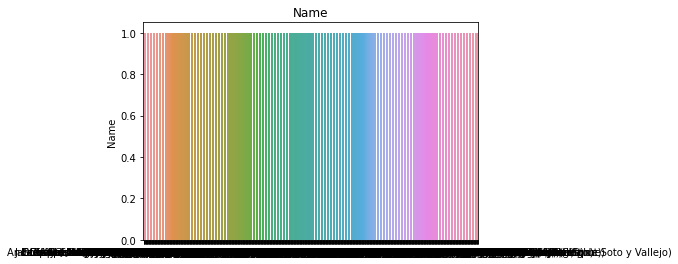

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


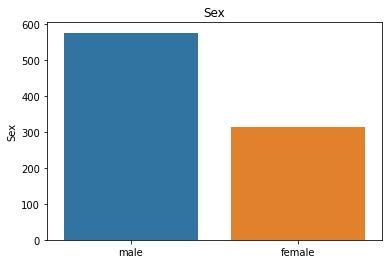

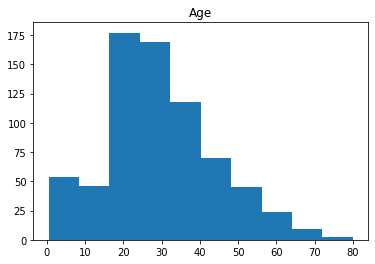

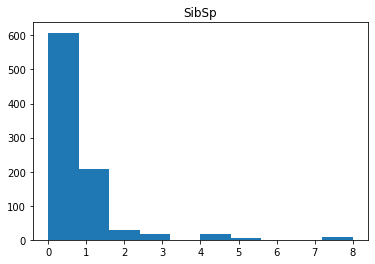

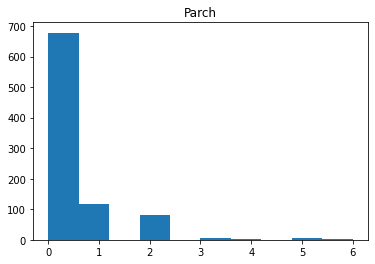

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


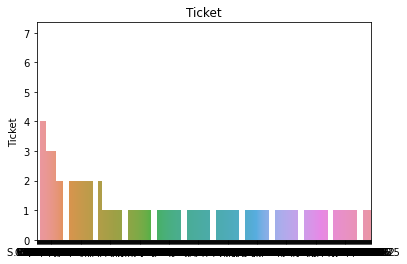

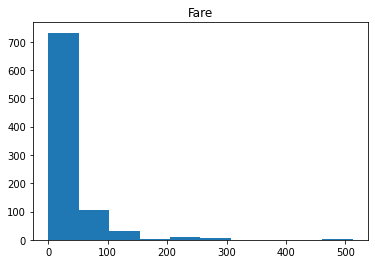

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


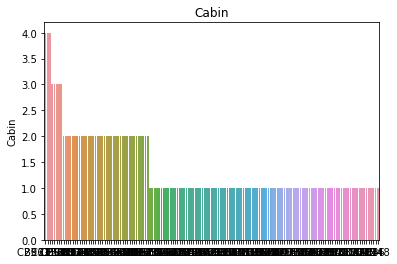

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


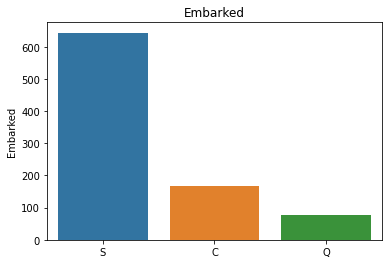

In [28]:

util.understanding(training)

In [29]:
print(training.Name.value_counts())
training['Sur'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

common_sur = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev']
training.Sur = training.Sur.apply(lambda x: 'Other' if x not in common_sur else x)
training.Sur.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64


Mr        517
Miss      182
Mrs       125
Master     40
Other      14
Dr          7
Rev         6
Name: Sur, dtype: int64

In [30]:
test['Sur'] = test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
test.Sur = test.Sur.apply(lambda x: 'Other' if x not in common_sur else x)

In [31]:
training.Sex = training.Sex.apply(lambda x: 0 if x == 'male' else 1)
training.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [32]:
test.Sex = test.Sex.apply(lambda x: 0 if x == 'male' else 1)

In [33]:
print(training.Age.value_counts())
median = round((training.Age.median()), 2)
median

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64


28.0

In [34]:
training.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [35]:
training.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [36]:
print(training.Ticket.value_counts())
training['Ticket_grouped'] = training.Ticket.apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0].lower() if len(x.replace('.', '').replace('/', '').split(' ')) > 1 else '0')
training.Ticket_grouped = training.Ticket_grouped.apply(lambda x: 0 if x == '0' else 1)
print(training.Ticket_grouped.value_counts())

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64
0    665
1    226
Name: Ticket_grouped, dtype: int64


In [37]:
test['Ticket_grouped'] = test.Ticket.apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0].lower() if len(x.replace('.', '').replace('/', '').split(' ')) > 1 else '0')
test.Ticket_grouped = test.Ticket_grouped.apply(lambda x: 0 if x == '0' else 1)

In [38]:
training.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

In [39]:
training.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

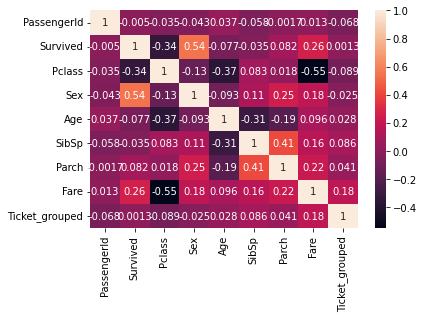

In [40]:
util.heat(training)

In [41]:
X_train = training.copy()
X_test = test.copy()

cols_to_drop = ['Cabin', 'Ticket', 'Name']

X_test.drop(cols_to_drop, axis=1, inplace=True)
X_train.drop(cols_to_drop, axis=1, inplace=True)

In [42]:
X_train.dropna(subset=['Embarked'], inplace=True)
X_test.dropna(subset=['Embarked'], inplace=True)

X_train.Age = X_train.Age.fillna(median)
X_test.Age = X_test.Age.fillna(median)
X_test.Fare = X_test.Fare.fillna(X_test.Fare.median())


In [43]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train, X_test = X_train.align(X_test, join='left', axis=1)


y_train = X_train.Survived
X_train.drop(['Survived'], axis=1, inplace=True)
X_test.drop(['Survived'], axis=1, inplace=True)


In [44]:
print(X_train.isna().any())


PassengerId       False
Pclass            False
Sex               False
Age               False
SibSp             False
Parch             False
Fare              False
Ticket_grouped    False
Embarked_C        False
Embarked_Q        False
Embarked_S        False
Sur_Dr            False
Sur_Master        False
Sur_Miss          False
Sur_Mr            False
Sur_Mrs           False
Sur_Other         False
Sur_Rev           False
dtype: bool


In [45]:
X_test.isna().any()

PassengerId       False
Pclass            False
Sex               False
Age               False
SibSp             False
Parch             False
Fare              False
Ticket_grouped    False
Embarked_C        False
Embarked_Q        False
Embarked_S        False
Sur_Dr            False
Sur_Master        False
Sur_Miss          False
Sur_Mr            False
Sur_Mrs           False
Sur_Other         False
Sur_Rev           False
dtype: bool

In [46]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=0)
cv = cross_val_score(xgb,X_train,y_train,cv=5)
print(cv.mean())

0.7897035485304386


In [47]:
rf = RandomForestClassifier(random_state=0)

cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv.mean())

rf.fit(X_train, y_train)

0.8132990541484162


RandomForestClassifier(random_state=0)

In [48]:
rf = RandomForestClassifier(random_state=0, n_estimators=90, max_depth=6)

cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv.mean())

rf.fit(X_train, y_train)

0.8211705706849489


RandomForestClassifier(max_depth=6, n_estimators=90, random_state=0)

In [49]:
pred = rf.predict(X_test).astype(int)

final_data = {'PassengerId': test.PassengerId, 'Survived': pred}
submission = pd.DataFrame(data=final_data)

submission.to_csv('submission.csv', index=False)